# Property analysis of potential inhibitors

In [2]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 7.5 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Draw
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit import RDLogger
from rdkit.Chem import AllChem, QED, RDConfig, Lipinski, Descriptors
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.Lipinski import NumHAcceptors, NumHDonors, NumRotatableBonds
from rdkit.Chem import AllChem, DataStructs

import os, sys, pickle
from rdkit.Chem import AllChem, QED, RDConfig, Lipinski, Descriptors
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

from tqdm import tqdm

In [8]:
def check_qed(mol):
  """ Calculates QED-score """
  return QED.qed(mol)

def check_sascore(mol):
  """ Calculates SAScore """
  return sascorer.calculateScore(mol)

def check_lipinski_ro5(mol):
  """ Checks Lipinski's rule of five for drig-like molecules """
  counter = 0
  counter += 1 if Chem.Lipinski.NumHDonors(mol) <= 5 else 0
  counter += 1 if Chem.Lipinski.NumHAcceptors(mol) <= 10 else 0
  counter += 1 if Chem.Descriptors.MolWt(mol) <= 500 else 0
  counter += 1 if Chem.Descriptors.MolLogP(mol) <= 5 else 0

  return counter >= 3

tox_df = pd.read_csv('/content/drive/MyDrive/models/tox_alerts.txt', sep='\t')
def check_toxicophore(mol):
  """ Returns the number of toxicophore groups in a molecule """
  count = 0
  for smarts in tox_df.SMARTS.to_list():
    pattern = Chem.MolFromSmarts(smarts)
    if mol.HasSubstructMatch(pattern)==True:
      count += 1
  return count

In [9]:
gen_mols = pd.read_csv('/content/drive/MyDrive/статья/Mols/all_goodmols_new.csv')

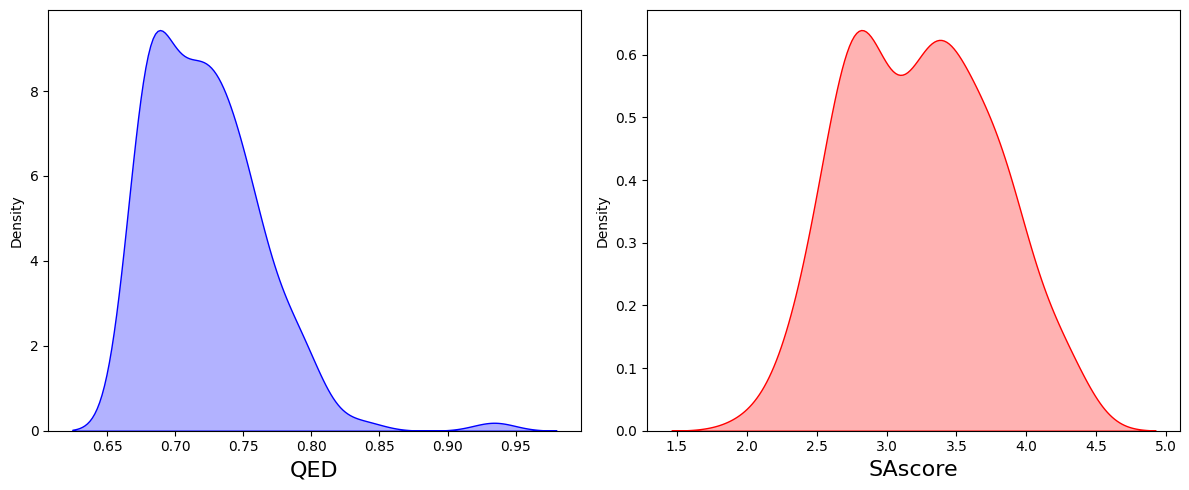

In [16]:
plt.figure(figsize=(12, 5))

# QED distribution
plt.subplot(1, 2, 1)
sns.kdeplot(gen_mols['QED'], fill=True, color="blue", alpha=0.3)

plt.xlabel("QED", fontsize=16)

# SAscore distribution
plt.subplot(1, 2, 2)
sns.kdeplot(gen_mols['sascore'], fill=True, color="red", alpha=0.3)

plt.xlabel("SAscore", fontsize=16)

plt.tight_layout()

plt.savefig('QED_SAscore.jpg', format='jpg', dpi=1000, bbox_inches='tight')

plt.show()

In [18]:
gen_mols['mol'] = gen_mols['Smiles'].apply(Chem.MolFromSmiles)
gen_mols['LogP'] = gen_mols['mol'].apply(MolLogP)
gen_mols['MW'] = gen_mols['mol'].apply(Descriptors.MolWt)
gen_mols['HBA'] = gen_mols['mol'].apply(NumHAcceptors)
gen_mols['HBD'] = gen_mols['mol'].apply(NumHDonors)
gen_mols['RotatableBonds'] = gen_mols['mol'].apply(NumRotatableBonds)
gen_mols['QED'] = gen_mols['mol'].apply(check_qed)
gen_mols['TPSA'] = gen_mols['mol'].apply(Descriptors.TPSA)

In [19]:
gen_mols = gen_mols.drop('mol', axis = 1)

## Evaluation of molecules from ChEMBL

In [17]:
lit_mols = pd.read_csv('/content/drive/MyDrive/статья/Data/all_mols.csv')

In [20]:
# filtering by molecules with similar activity
lit_mols = lit_mols[lit_mols['pIC50']>7.4]

In [21]:
lit_mols['mol'] = lit_mols['Smiles'].apply(Chem.MolFromSmiles)
lit_mols['LogP'] = lit_mols['mol'].apply(MolLogP)
lit_mols['MW'] = lit_mols['mol'].apply(Descriptors.MolWt)
lit_mols['HBA'] = lit_mols['mol'].apply(NumHAcceptors)
lit_mols['HBD'] = lit_mols['mol'].apply(NumHDonors)
lit_mols['RotatableBonds'] = lit_mols['mol'].apply(NumRotatableBonds)
lit_mols['QED'] = lit_mols['mol'].apply(check_qed)
lit_mols['TPSA'] = lit_mols['mol'].apply(Descriptors.TPSA)

In [22]:
lit_mols = lit_mols.drop('mol', axis = 1)

In [24]:
def set_min_max_ticks(ax):
    ymin, ymax = ax.get_ylim()
    ax.set_yticks([ymin, ymax])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

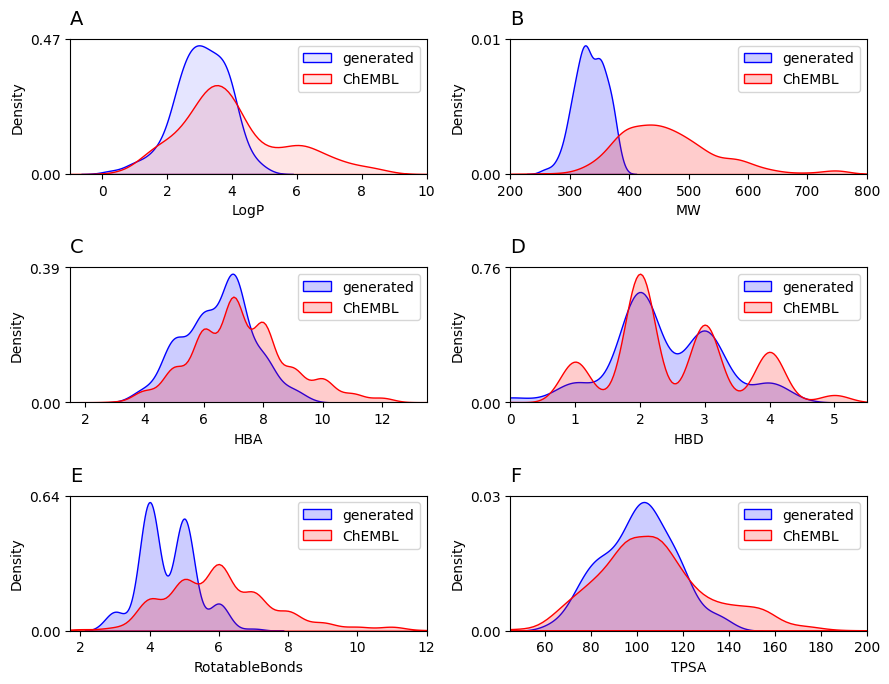

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(9, 7))

# LogP
sns.kdeplot(gen_mols['LogP'], fill=True, color="blue", label="generated", alpha=0.1, ax=axes[0, 0])
sns.kdeplot(lit_mols['LogP'], fill=True, color="red", label="ChEMBL", alpha=0.1, ax=axes[0, 0])
axes[0, 0].set_xlabel("LogP")
axes[0, 0].set_ylabel("Density")
axes[0, 0].set_xlim(-1, 10)
axes[0, 0].legend()
set_min_max_ticks(axes[0, 0])
axes[0, 0].text(0, 1.22, 'A', transform=axes[0, 0].transAxes, fontsize=14, va='top', ha='left')

# MW
sns.kdeplot(gen_mols['MW'], fill=True, color="blue", label="generated", alpha=0.2, ax=axes[0, 1])
sns.kdeplot(lit_mols['MW'], fill=True, color="red", label="ChEMBL", alpha=0.2, ax=axes[0, 1])
axes[0, 1].set_xlabel("MW")
axes[0, 1].set_ylabel("Density")
axes[0, 1].set_xlim(200, 800)
axes[0, 1].legend()
set_min_max_ticks(axes[0, 1])
axes[0, 1].text(0, 1.22, 'B', transform=axes[0, 1].transAxes, fontsize=14, va='top', ha='left')

# HBA
sns.kdeplot(gen_mols['HBA'], fill=True, color="blue", label="generated", alpha=0.2, ax=axes[1, 0])
sns.kdeplot(lit_mols['HBA'], fill=True, color="red", label="ChEMBL", alpha=0.2, ax=axes[1, 0])
axes[1, 0].set_xlabel("HBA")
axes[1, 0].set_ylabel("Density")
axes[1, 0].set_xlim(1.5, 13.5)
axes[1, 0].legend()
set_min_max_ticks(axes[1, 0])
axes[1, 0].text(0, 1.22, 'C', transform=axes[1, 0].transAxes, fontsize=14,  va='top', ha='left')

# HBD
sns.kdeplot(gen_mols['HBD'], fill=True, color="blue", label="generated", alpha=0.2, ax=axes[1, 1])
sns.kdeplot(lit_mols['HBD'], fill=True, color="red", label="ChEMBL", alpha=0.2, ax=axes[1, 1])
axes[1, 1].set_xlabel("HBD")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_xlim(0, 5.5)
axes[1, 1].legend()
set_min_max_ticks(axes[1, 1])
axes[1, 1].text(0, 1.22, 'D', transform=axes[1, 1].transAxes, fontsize=14, va='top', ha='left')

# RotatableBonds
sns.kdeplot(gen_mols['RotatableBonds'], fill=True, color="blue", label="generated", alpha=0.2, ax=axes[2, 0])
sns.kdeplot(lit_mols['RotatableBonds'], fill=True, color="red", label="ChEMBL", alpha=0.2, ax=axes[2, 0])
axes[2, 0].set_xlabel("RotatableBonds")
axes[2, 0].set_ylabel("Density")
axes[2, 0].set_xlim(1.7, 12)
axes[2, 0].legend()
set_min_max_ticks(axes[2, 0])
axes[2, 0].text(0, 1.22, 'E', transform=axes[2, 0].transAxes, fontsize=14, va='top', ha='left')

# TPSA
sns.kdeplot(gen_mols['TPSA'], fill=True, color="blue", label="generated", alpha=0.2, ax=axes[2, 1])
sns.kdeplot(lit_mols['TPSA'], fill=True, color="red", label="ChEMBL", alpha=0.2, ax=axes[2, 1])
axes[2, 1].set_xlabel("TPSA")
axes[2, 1].set_ylabel("Density")
axes[2, 1].set_xlim(45, 200)
axes[2, 1].legend()
set_min_max_ticks(axes[2, 1])
axes[2, 1].text(0, 1.22, 'F', transform=axes[2, 1].transAxes, fontsize=14,  va='top', ha='left')

plt.tight_layout()

plt.savefig('Calculated_properties.jpg', format='jpg', dpi=1000, bbox_inches='tight')

plt.show()

# Tanimoto similarity

In [ ]:
lit_mols['mol'] = lit_mols.Smiles.apply(Chem.MolFromSmiles)
lit_mols['QED'] = lit_mols.mol.apply(check_qed)
lit_mols['sascore'] = lit_mols.mol.apply(check_sascore)
lit_mols['lipinski_ro5'] = lit_mols.mol.apply(check_lipinski_ro5)
lit_mols['tox_groups'] = lit_mols.mol.apply(check_toxicophore)

In [28]:
lit_mols = lit_mols.drop('mol', axis = 1)

In [32]:
# Selection according to evaluation metrics
filtered_df = lit_mols[(lit_mols['sascore'] < 6) &
                 (lit_mols['lipinski_ro5'] == True) &
                 (lit_mols['QED'] > 0.67) &
                 (lit_mols['tox_groups']==0)]

In [30]:
len(filtered_df)

122

In [34]:
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

In [ ]:
# Getting fingerprints for molecules in each of the data frames
fingerprints_df = [get_fingerprint(smiles) for smiles in gen_mols['Smiles']]
fingerprints_lit_df = [get_fingerprint(smiles) for smiles in filtered_df['Smiles']]

similarity_matrix = np.zeros((len(fingerprints_df), len(fingerprints_lit_df)))

for i, fp1 in enumerate(fingerprints_df):
    for j, fp2 in enumerate(fingerprints_lit_df):
        if fp1 is not None and fp2 is not None:
            similarity_matrix[i, j] = DataStructs.TanimotoSimilarity(fp1, fp2)
        else:
            similarity_matrix[i, j] = np.nan  # Если одна из молекул невалидна

In [36]:
index_labels = [f'gen_mol_{i+1}' for i in range(len(gen_mols))]
column_labels = [f'lit_mol_{i+1}' for i in range(len(filtered_df))]

similarity_df = pd.DataFrame(similarity_matrix, index=index_labels, columns=column_labels)

In [ ]:
(similarity_df < 0.3).sum().sum()

16619

In [ ]:
(similarity_df > 0.5).sum().sum()

4

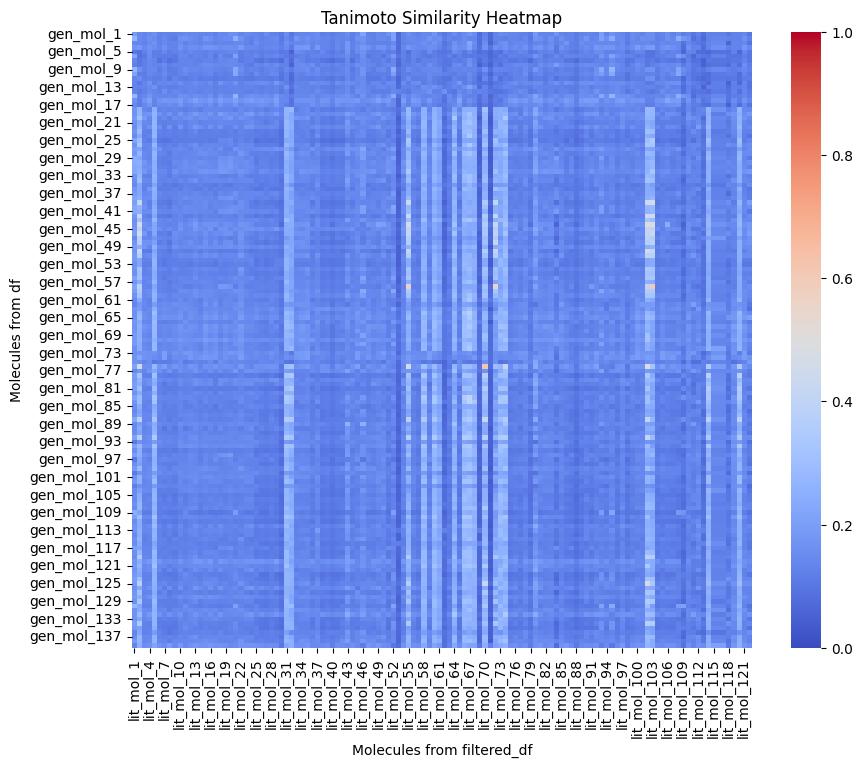

In [ ]:
# Visualize the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='coolwarm', annot=False, vmin=0, vmax=1)
plt.title('Tanimoto Similarity Heatmap')
plt.xlabel('Molecules from filtered_df')
plt.ylabel('Molecules from df')
plt.show()

In [ ]:
sns.distplot(-np.log10(df['IC50']*(10**(-9))), hist=True, kde=False,
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('pIC50 distribution ')
plt.xlabel('pIC50')
plt.ylabel('Frequency')

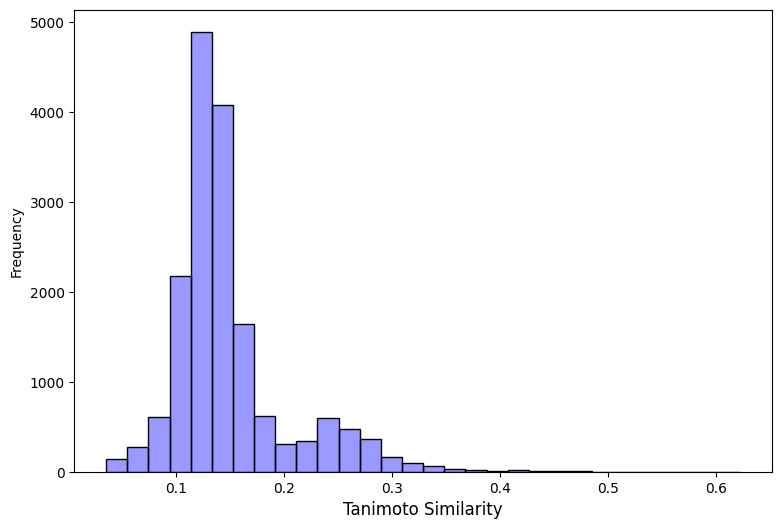

In [55]:
similarity_values = similarity_df.values.flatten()
similarity_values = similarity_values[~np.isnan(similarity_values)]

plt.figure(figsize=(9, 6))
sns.histplot(similarity_values, kde=False, bins=30, color="blue", alpha=0.4)
plt.xlabel('Tanimoto Similarity', fontsize = 12)
plt.ylabel('Frequency')
plt.grid(False)

plt.savefig('Tanimoto_distribution.jpg', format='jpg', dpi=1000, bbox_inches='tight')

plt.show()